# Projet Titanic

L'objectif est de suivre toutes les étapes classiques d’un pipeline de machine learning :
- Préparation des données (nettoyage, transformation)
- Séparation des données
- Entraînement du modèle
- Évaluation
- Prédiction finale
Importer les bibliothèques nécessaires.

In [75]:
!pip  install pandas
!pip install plotly
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 11.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]


In [83]:
# Importation des bibliothèques
import pandas as pd
import plotly as pt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#  Chargement des données

In [89]:
train = pd.read_csv("../titanic-project/titanic_data/train.csv")
test = pd.read_csv("../titanic-project/titanic_data/test.csv")
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Nettoyage des données

In [90]:
# On supprime les colonnes inutiles
train = train.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"])

# Remplissage des valeurs manquantes
train["Age"] = train["Age"].fillna(train["Age"].median())
train["Embarked"] = train["Embarked"].fillna(train["Embarked"].mode()[0])

# Encodage des variables catégorielles
le_sex = LabelEncoder()
le_embarked = LabelEncoder()
train["Sex"] = le_sex.fit_transform(train["Sex"])
train["Embarked"] = le_embarked.fit_transform(train["Embarked"])

train.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

### Hypothèses

Hypothèses :

Les femmes ont un taux de survie plus élevé que les hommes, en particulier entre 20 et 40 ans.

Les passagers de première classe ont plus de chances de survivre que ceux de troisième classe et deuxième classe.

Les plus jeunes ont de meilleures chance de survie, surtout chez les femmes.

Le prix du billet influe sur le taux de survie.

Le nombre de relations parents/enfants et de frères/soeurs/époux influent peut-être(?) sur le taux de survie.

La cabine, le port d'embarquement, le billet et le nom n'influe pas sur le taux de survie.

On ne conserverait pas Cabine, Embarked, Ticket et Name dans la BDD.

Le titre associé à la variable de Nom (Mr, Mrs, Cpt etc ...) peut nous permettre de reconstituer les âges manquants.

On aurait donc en tant que variables dans notre BDD train finale : Sex, Age, Pclass, SibSp, Parch, Fare

Il faudra donc encoder la variable Sex, et peut être normaliser les variables Age/SibSp/Parch/Fare selon les besoins du modèle.

##  Exploration des données

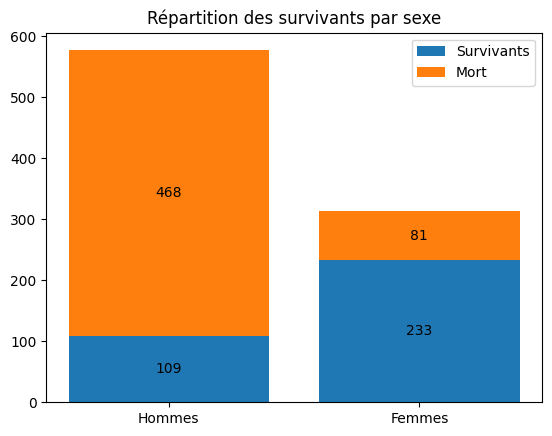

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
train = pd.read_csv('../titanic-project/titanic_data/train.csv')

# Compter le nombre total d'hommes et de femmes et le nombre de survivants
males_total = len(train.loc[(train['Sex'] == 'male')])
females_total = len(train.loc[(train['Sex'] == 'female')])
# print(f"Males total: {males_total}\nFemales total: {females_total}")
males_total_survived = len(train.loc[(train['Sex'] == 'male') & (train['Survived'] == 1)])
females_total_survived = len(train.loc[(train['Sex'] == 'female') & (train['Survived'] == 1)])
# print(f"Males Survivants: {males_total_survived}\nFemales Survivants: {females_total_survived}")

count = {
    "Survivants": [males_total_survived, females_total_survived],
    "Mort": [males_total-males_total_survived, females_total-females_total_survived]
}
# print(count)

fig, ax = plt.subplots()
x = np.zeros(2) # list = [0,0 hommes ; 0,0 femmes]
ax.set_title("Répartition des survivants par sexe")
for key, count in count.items():
    i = ax.bar(('Hommes', 'Femmes'),count, width=0.8, bottom=x, label=key)
    x+=count
    ax.legend()
    ax.bar_label(i, label_type="center")

plt.show()



Le nombre total et le nombre de survivants et morts par class sur un graphique


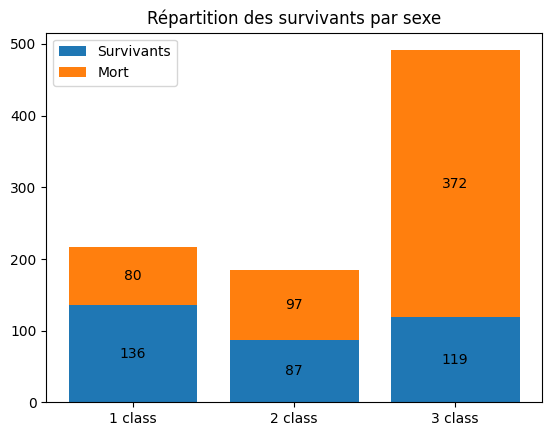

In [46]:
train = pd.read_csv('../titanic-project/titanic_data/train.csv')

# Compter le nombre total d'hommes et de femmes par class et le nombre de survivants par class
first_class_total = len(train.loc[(train['Pclass'] == 1)])
second_class_total = len(train.loc[(train['Pclass'] == 2)])
third_class_total = len(train.loc[(train['Pclass'] == 3)])
first_class_total_survived = len(train.loc[(train['Pclass'] == 1) & (train['Survived'] == 1)])
second_class_total_survived = len(train.loc[(train['Pclass'] == 2) & (train['Survived'] == 1)])
third_class_total_survived = len(train.loc[(train['Pclass'] == 3) & (train['Survived'] == 1)])

count = {
    "Survivants": [first_class_total_survived, second_class_total_survived, third_class_total_survived],
    "Mort": [first_class_total-first_class_total_survived, second_class_total-second_class_total_survived, third_class_total-third_class_total_survived]
}
# print(count)

#Visualiser
fig, ax = plt.subplots()
x = np.zeros(3) # list = [0,0 1 class ; 0,0 2 class; 0, 0; 3 class]
ax.set_title("Répartition des survivants par sexe")
for key, count in count.items():
    i = ax.bar(('1 class', '2 class', '3 class'),count, width=0.8, bottom=x, label=key)
    x+=count
    ax.legend()
    ax.bar_label(i, label_type="center")

plt.show()


Examinez la répartition des passagers par âge et la répartition des survivants, hommes et femmes, par âge.

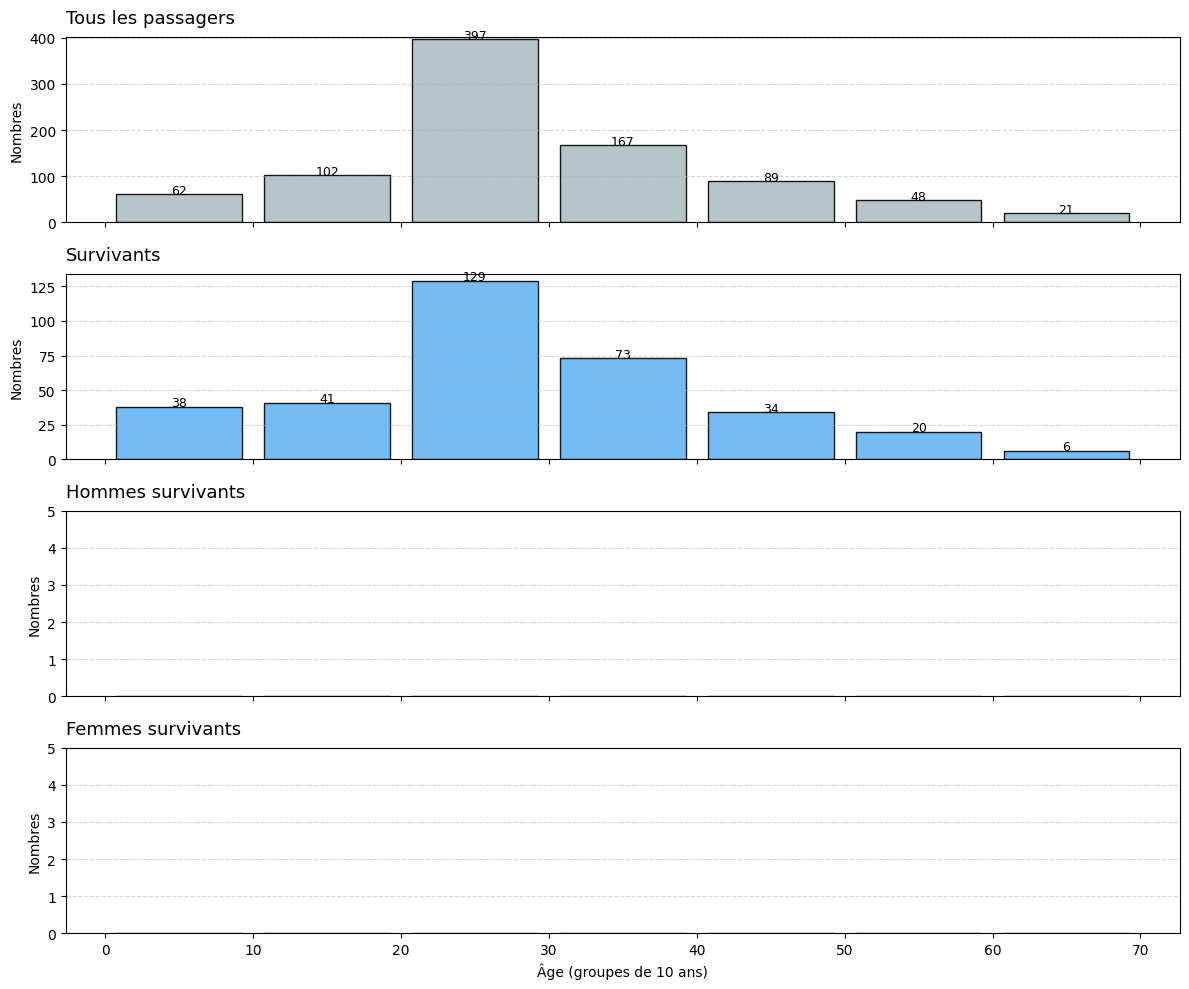

In [ ]:
# groupes
groups = {
    'Tous les passagers': train,
    'Survivants': train[train['Survived'] == 1],
    'Hommes survivants': train[(train['Survived'] == 1) & (train['Sex'] == 'male')],
    'Femmes survivants': train[(train['Survived'] == 1) & (train['Sex'] == 'female')],
}
bins = np.arange(0, 80, 10)
colors = ['#B0BEC5', '#64B5F6', '#EF5350', '#AB47BC']

#Visualiser
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

for ax, (title, data), color in zip(axs, groups.items(), colors):
    ages = data['Age'].dropna()
    counts, edges, _ = ax.hist(ages, bins=bins, color=color, edgecolor='black', alpha=0.9, rwidth=0.85)
    
    for i, count in enumerate(counts):
        if count > 0:
            ax.text(edges[i] + 5, count + 0.5, f'{int(count)}', ha='center', fontsize=9)
    
    ax.set_title(title, fontsize=13, loc='left', pad=10)
    ax.set_ylabel('Nombres')
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.set_ylim(0, max(counts) + 5)

axs[-1].set_xlabel('Âge (groupes de 10 ans)')
axs[-1].set_xticks(bins)

plt.tight_layout()
plt.show()

# from collections import Counter

# #Sélectionnons les listes de passagers en groupes distincts
# survivors = train.loc[(train['Survived'] == 1)]
# male_survivors = train.loc[((train['Sex'] == 'male') & (train['Survived'] == 1))]
# female_survivors = train.loc[((train['Sex'] == 'female') & (train['Survived'] == 1))]

# #Nombre d'âges
# num_of_ages = len(dict(Counter(survivors['Age'])).keys())

# #Visualiser
# fig, axs = plt.subplots(2,2)
# fig.set_figwidth(20)
# fig.set_figheight(10)
# psgrs = [['Tous les passagers', 'Survivants Total'], ['Hommes survivants', 'Femmes survivants']]
# for i, surv in enumerate([[train, survivors], [male_survivors, female_survivors]]):
#     for j, subsurv in enumerate(surv):
#         axs[i][j].hist(subsurv['Age'], bins=num_of_ages, rwidth=0.8)
#         axs[i][j].set_title(psgrs[i][j])
#         axs[i][j].set_xlabel('Age')
#         axs[i][j].set_ylabel('Nombre de passagers')
#         axs[i][j].set_ylim(0,30)
#         axs[i][j].set_xlim(0,70)
# plt.show()

In [95]:
# Enfants vs adultes (moins de 18 ans)
train["IsChild"] = train["Age"] < 18
child_survival = train.groupby("IsChild")["Survived"].mean()
print("Taux de survie: Enfants vs Adultes")
print(child_survival)

Taux de survie: Enfants vs Adultes
IsChild
False    0.361183
True     0.539823
Name: Survived, dtype: float64


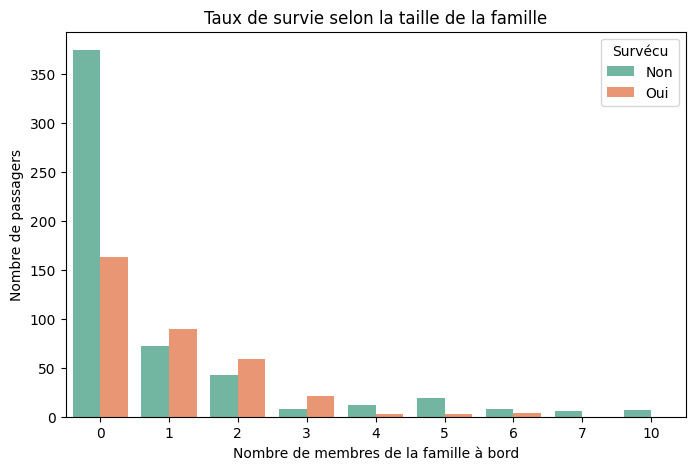

In [97]:
train["FamilySize"] = train["SibSp"] + train["Parch"]


plt.figure(figsize=(8,5))
sns.countplot(x="FamilySize", hue="Survived", data=train, palette="Set2")

plt.title("Taux de survie selon la taille de la famille")
plt.xlabel("Nombre de membres de la famille à bord")
plt.ylabel("Nombre de passagers")
plt.legend(title="Survécu", labels=["Non", "Oui"])
plt.show()

Noms et âges

Représentons la dépendance de l'âge par rapport au titre sous la forme d'un ensemble de diagrammes en boîte.

/tmp/ipykernel_960/4292307209.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(ages.values(), labels=titles)


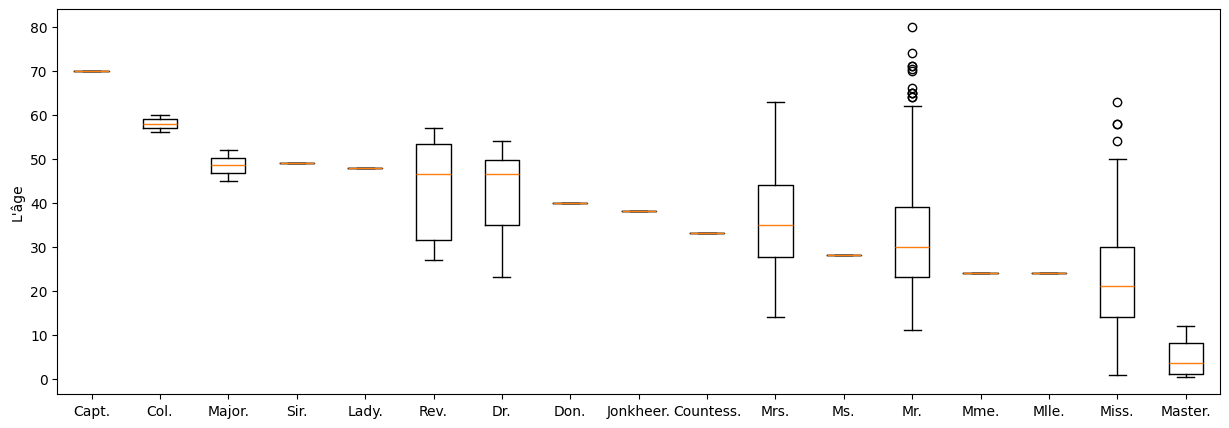

In [49]:
titles = ("Capt.","Col.","Major.","Sir.","Lady.","Rev.","Dr.","Don.","Jonkheer.","Countess.","Mrs.","Ms.","Mr.","Mme.","Mlle.","Miss.","Master.")

#Créons une liste de titres pour chaque passagers
titled_names = []
for names in train.Name:
    for title in titles:
        if title in names.split(' '):
            titled_names.append(title)
            break
# print(titled_names)

#delete the column Title and recreate
#Ajouter une nouvelle colonne au dataframe - Titre
train.insert(12, 'Title', titled_names)
# print(train['Title'])
# train = train.drop('Title', axis=1)

#Créer un dictionnaire avec des paires de titre : liste des âges
ages = dict.fromkeys(titles, [])
for i, title in enumerate(train.Title):
    if not pd.isna(train.Age[i]):
        ages[title] = ages[title] + [train.Age[i]]

#Visualiser
fig, ax = plt.subplots(figsize=(15, 5))
ax.boxplot(ages.values(), labels=titles)
ax.set_ylabel("L'âge")
plt.show()